In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statistics
import time
import glob
import os
import feather
import scipy.stats as stats
import itertools
from sklearn.pipeline import make_pipeline
import sklearn
sns.set(style="whitegrid")

In [2]:
# feature extractors

import pycatch22
from kats.tsfeatures.tsfeatures import TsFeatures
from kats.consts import TimeSeriesData
tsFeatures = TsFeatures()
from tsfresh import extract_features
import tsfel

--------------------------------------

### LOAD DATA

In [3]:
from sktime.datasets import load_unit_test

# load training data
X_train, y_train = load_unit_test(split="train", return_X_y=True)

# load test data
X_test, y_test = load_unit_test(split="test", return_X_y=True)

X_train

,dim_0
0,0 573.0 1 375.0 2 301.0 3 ...
1,0 394.0 1 264.0 2 140.0 3 ...
2,0 603.0 1 348.0 2 176.0 3 ...
3,0 428.0 1 309.0 2 199.0 3 ...
4,0 372.0 1 310.0 2 203.0 3 ...
5,0 448.0 1 344.0 2 183.0 3 ...
6,0 621.0 1 322.0 2 221.0 3 ...
7,0 597.0 1 409.0 2 142.0 3 ...
8,0 525.0 1 431.0 2 248.0 3 ...
9,0 587.0 1 382.0 2 165.0 3 ...


In [4]:
def seriesToNumpy(s):
    return s.values[0].to_numpy()

In [5]:
from sktime.datasets import load_arrow_head
X, y = load_arrow_head()

ts = seriesToNumpy(X.iloc[1])
len(ts)

251

In [6]:
from sktime.datasets import load_gunpoint
X, y = load_gunpoint()

ts = seriesToNumpy(X.iloc[1])
len(ts)

150

In [7]:
from sktime.datasets import load_osuleaf
X, y = load_osuleaf()

ts = seriesToNumpy(X.iloc[1])
len(ts)

427

In [8]:
from sktime.datasets import load_italy_power_demand
X, y = load_italy_power_demand()

ts = seriesToNumpy(X.iloc[1])
len(ts)

24

In [9]:
'''
# multivariate
from sktime.datasets import load_japanese_vowels
X, y = load_japanese_vowels()

ts = seriesToNumpy(X.iloc[1])
len(ts)
X
'''

'\n# multivariate\nfrom sktime.datasets import load_japanese_vowels\nX, y = load_japanese_vowels()\n\nts = seriesToNumpy(X.iloc[1])\nlen(ts)\nX\n'

Print time series':

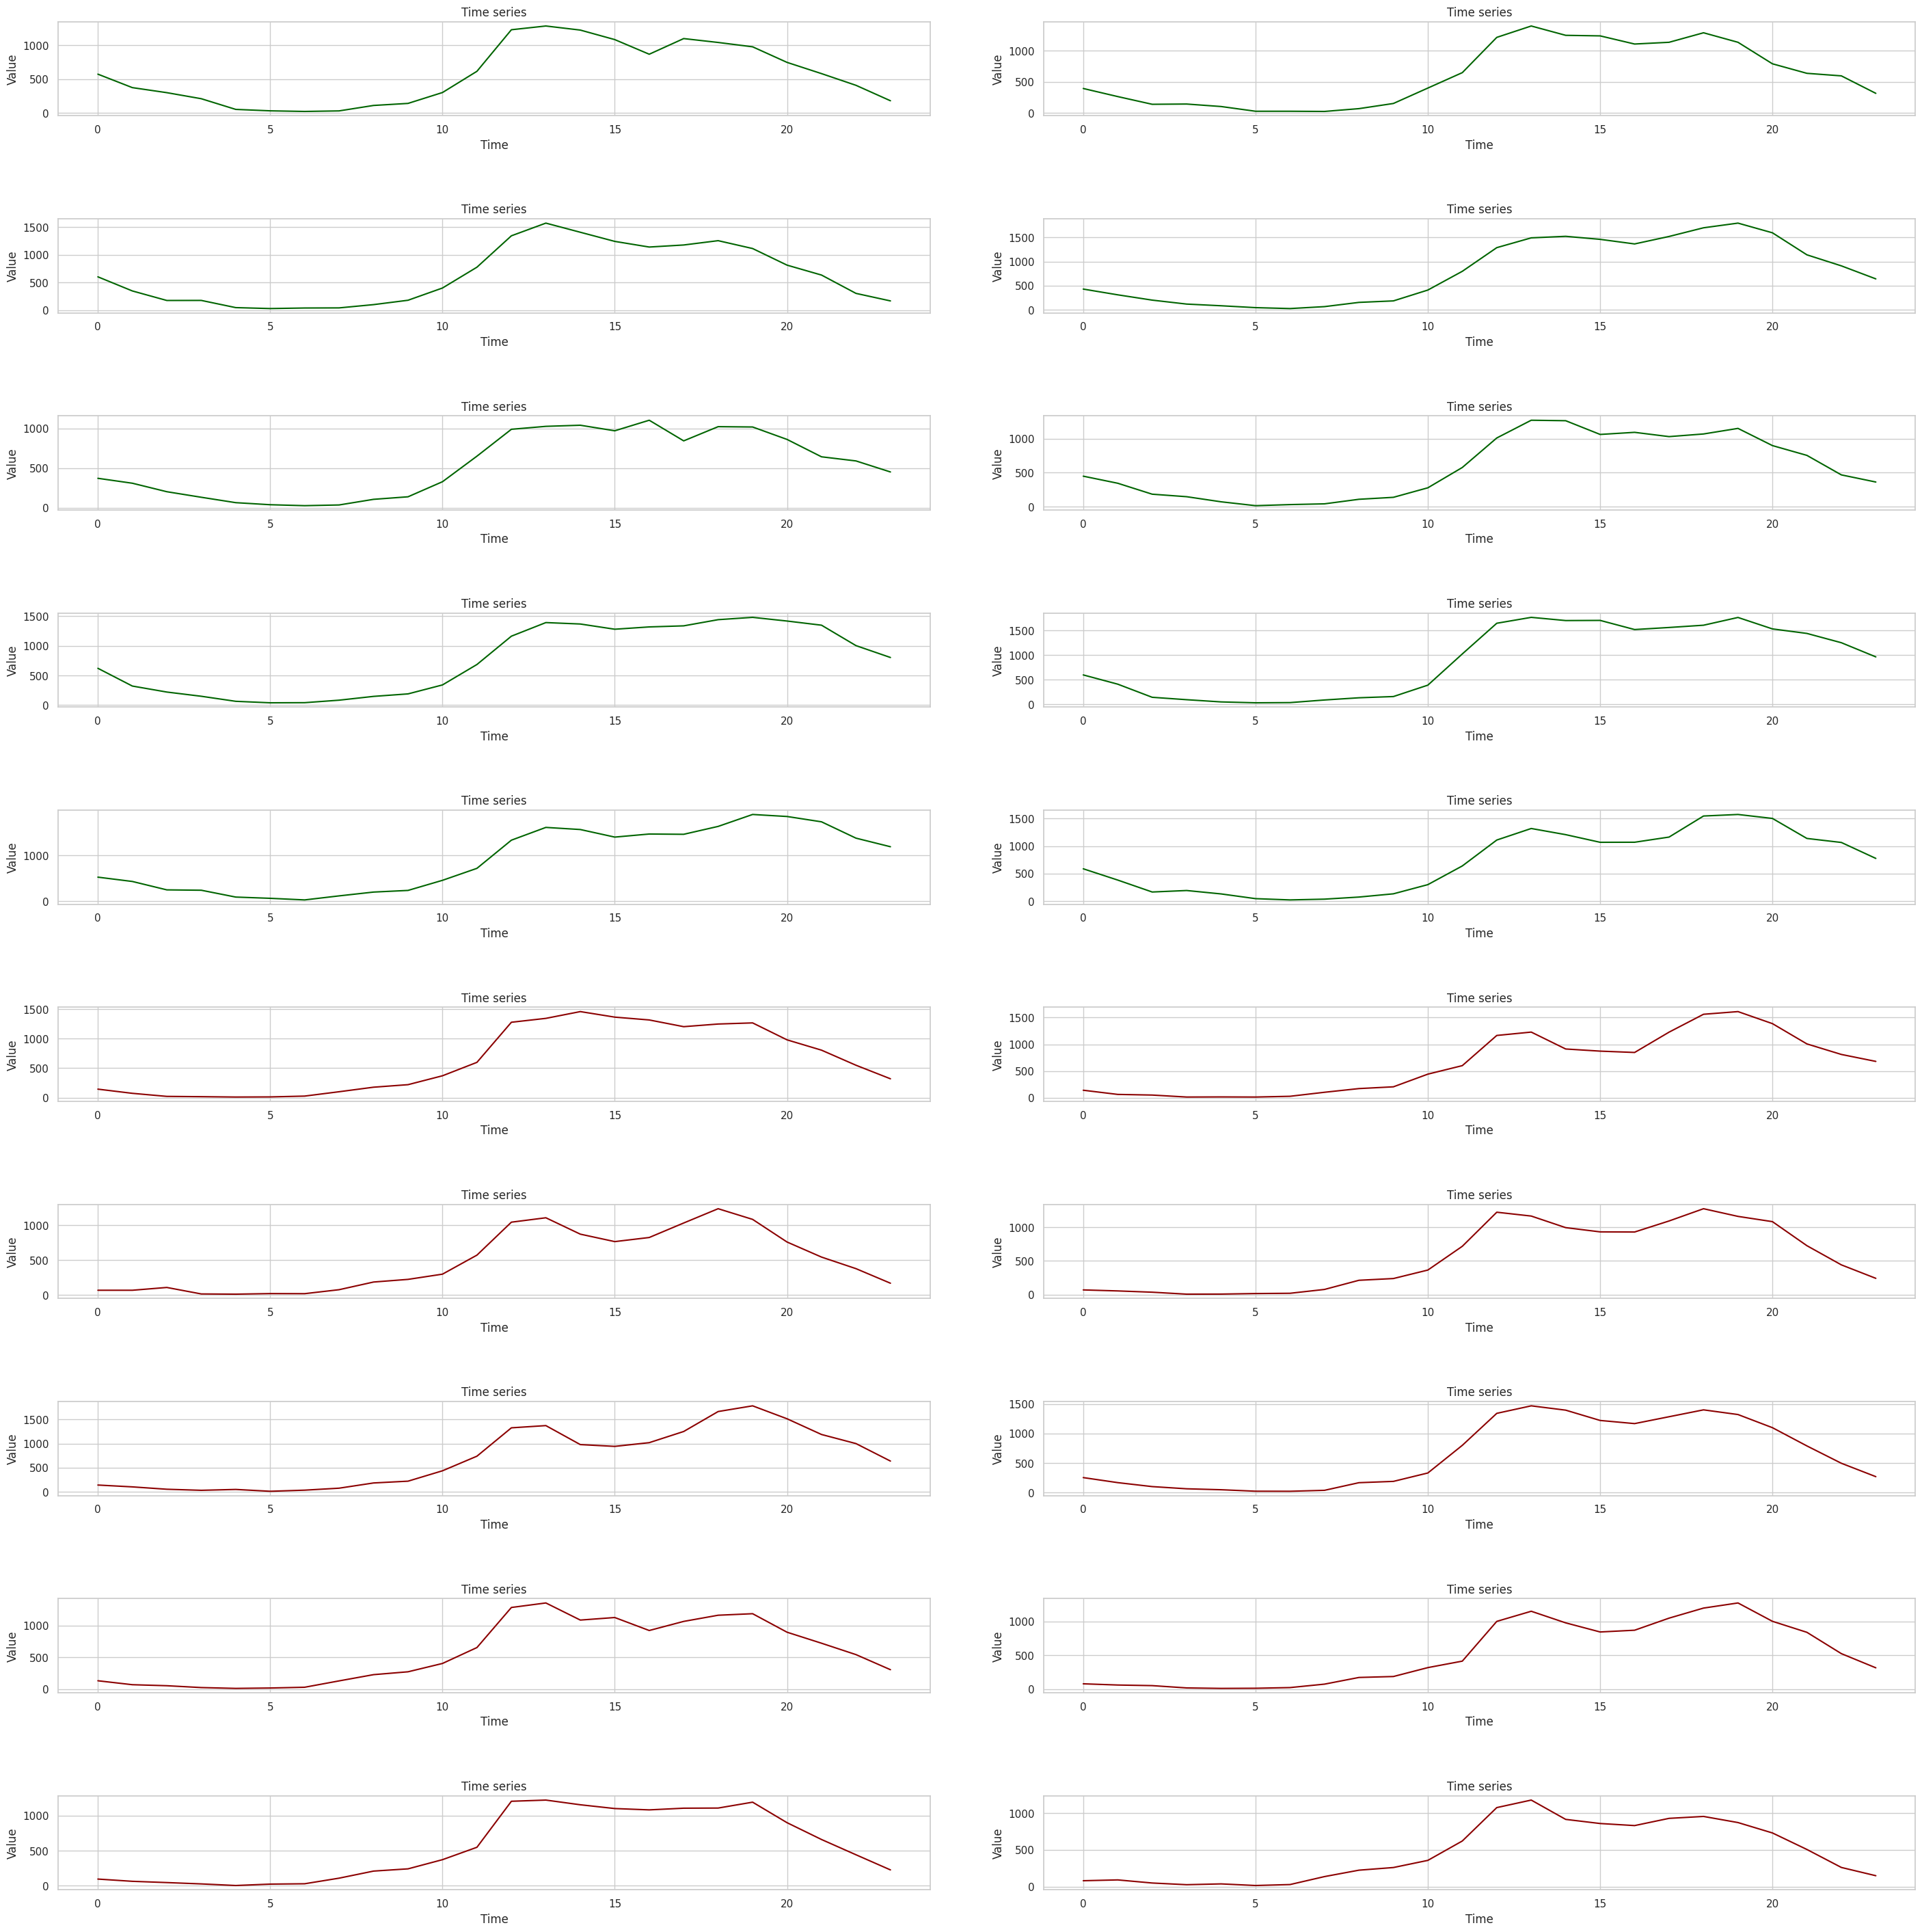

In [10]:


def plotTimeSeries(df, label):
    
    nbrTS = len(df)
    
    cols = 2
    rows = int(np.ceil(nbrTS/cols))
    
    fig, ax = plt.subplots(rows, cols, figsize=(30, 30))
    # using padding
    fig.tight_layout(pad=7.0)
    
    # colours
    colours = ['darkgreen', 'darkred', 'midnightblue', 'goldenrod', 'darkviolet']
    
    axes = ax.flatten()
    for row, a in zip(range(nbrTS), axes):
        
        ts = seriesToNumpy(df.iloc[row])
        
        a.plot(range(len(ts)), ts, color=colours[int(label[row])-1])
        a.set_title('Time series')
        a.set_xlabel('Time')
        a.set_ylabel('Value')



plotTimeSeries(X_train, y_train)

--------------------------------------

Transform into usable form for _feast_ and _tsfeatures_ in R.

In [11]:
def getUsefulFrame(df):
    
    nbrTS = len(df)
    result = pd.DataFrame()
    
    for i in range(nbrTS):
        
        tmpFrame = pd.DataFrame()
        values = df.iloc[i].values[0].to_numpy()
        length = len(values)
         
        tmpFrame['id']        = length * [i+1]
        tmpFrame['timepoint'] = np.arange (1, length+1, 1.0)
        tmpFrame['value']     = values
        tmpFrame['Name']      = length * ['classifierTesting']
        tmpFrame['Keywords']  = length * ['load_unit_test']
        tmpFrame['Length']    = length * [length]
        
        result = pd.concat([result, tmpFrame], ignore_index = True)
        
    return result

In [12]:
trainingSet = getUsefulFrame(X_train)
testingSet  = getUsefulFrame(X_test)

trainingSet.to_feather('divers/trainingSet.feather')
testingSet.to_feather('divers/testingSet.feather')

Now load calculated features from R:

In [13]:
X_train_feasts = feather.read_dataframe('divers/X_train_feasts.feather')
X_test_feasts  = feather.read_dataframe('divers/X_test_feasts.feather')

def transformFrame(df):
    tmp1 = pd.pivot_table(df, index=['id'], columns=['names'])
    tmp2 = tmp1.reset_index().drop(columns = 'id')
    tmp2.columns = [col[1]for col in tmp2.columns]
    
    return tmp2

In [14]:
X_train_feasts = transformFrame(X_train_feasts)
X_test_feasts  = transformFrame(X_test_feasts)


/home/jastoj/.local/share/virtualenvs/katsTest-PKZRu5Zk/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


--------------------------------------

In [15]:
class MyFeasts:
    
    # returns the class itself (shouldn't do anything on data --> fitting, the transformation is done)
    def fit(X, y):
        return MyFeasts
    
    # compute the features for all time series using the compute function
    def transform(X):
        return X

In [16]:
# feasts
from sktime.classification.feature_based import Catch22Classifier
from sklearn.ensemble import RandomForestClassifier

# storage
scores = []

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train_feasts, y_train)

scores.append(clf.score(X_test_feasts, y_test))
scores

[0.9090909090909091]

--------------------------------------

### CREATE CLASSES

#### CATCH22

In [17]:
class MyCatch22:
    
    # returns the class itself (shouldn't do anything on data --> fitting, the transformation is done)
    def fit(X, y):
        return MyCatch22
    
    # compute the features for all time series using the compute function
    def transform(df):
        
        # stores the computed features
        transformedFrame = pd.DataFrame()
    
        colNames = df.columns
        nbrCols  = len(colNames)
        nbrTS    = len(df)

        for col in range(nbrCols):
            dim = colNames[col]
            currentDim = pd.DataFrame()
        
            for row in range(nbrTS):
            
                ts = df.iloc[row].values[0].tolist()
                rawFeat = pycatch22.catch22_all(ts)

                # create a dictionary with the feature name as key and the value as value
                dictionary = {}
                for name,value in zip(rawFeat['names'],rawFeat['values']):
                    dictionary[name] = [value]
            
                # store feature values in a frame (feature names = columns)
                features = pd.DataFrame.from_dict(dictionary)
                currentDim = pd.concat([currentDim, features], axis=0, ignore_index=True)
        
            currentDim.columns = [dim + '_' + originalName for originalName in currentDim.columns]
            transformedFrame = pd.concat([transformedFrame, currentDim], axis=1, ignore_index=False)
        
        return transformedFrame.dropna(axis=1)
    
    

In [18]:
#MyCatch22.transform(X_test)

#### KATS

In [19]:
class MyKats:
    
    # returns the class itself (shouldn't do anything on data --> fitting, the transformation is done)
    def fit(X, y):
        return MyKats
    
    # compute the features for all time series using the compute function
    def transform(df):
        
        # stores the computed features
        transformedFrame = pd.DataFrame()
    
        colNames = df.columns
        nbrCols  = len(colNames)
        nbrTS    = len(df)

        for col in range(nbrCols):
            dim = colNames[col]
            currentDim = pd.DataFrame()
        
            for row in range(nbrTS):
                
                # transform data to dataframe
                ts = df.iloc[row].values[0].to_frame()
                ts.columns = ['value']
                
                # returns dictionary with features as keys and values as values
                rawFeatDict = TsFeatures().transform(ts)
        
                # then create a dataframe, and from that a dataframe row per feature
                features = pd.DataFrame.from_dict([rawFeatDict])
                currentDim = pd.concat([currentDim, features], axis=0, ignore_index=True)
        
            currentDim.columns = [dim + '_' + originalName for originalName in currentDim.columns]
            transformedFrame = pd.concat([transformedFrame, currentDim], axis=1, ignore_index=False)
        
        return transformedFrame.dropna(axis=1)
    

In [20]:
#MyKats.transform(X_train)

#### TSFRESH

In [21]:
class MyTsfresh:
    
    # returns the class itself (shouldn't do anything on data --> fitting, the transformation is done)
    def fit(X, y):
        return MyTsfresh
    
    # compute the features for all time series using the compute function
    def transform(df):
        
        # stores the computed features
        transformedFrame = pd.DataFrame()
    
        colNames = df.columns
        nbrCols  = len(colNames)
        nbrTS    = len(df)

        for col in range(nbrCols):
            dim = colNames[col]
            currentDim = pd.DataFrame()
        
            for row in range(nbrTS):
                
                # transform data to dataframe
                ts = df.iloc[row].values[0].to_frame()
                ts[1] = len(ts) * [1]
                ts[2] = np.arange (1, len(ts)+1, 1.0)
                ts.columns = ['value', 'id', 'time']
                
                # get features
                features = extract_features(ts, column_id='id', column_value = 'value', column_sort = 'time')
                currentDim = pd.concat([currentDim, features], axis=0, ignore_index=True)
        
            currentDim.columns = [dim + '_' + originalName for originalName in currentDim.columns]
            transformedFrame = pd.concat([transformedFrame, currentDim], axis=1, ignore_index=False)
        
        return transformedFrame.dropna(axis=1)

In [22]:
#MyTsfresh.transform(X_train)

#### TSFEL

In [23]:
class MyTsfel:
    # returns the class itself (shouldn't do anything on data --> fitting, the transformation is done)
    def fit(X, y):
        return MyTsfel
    
    # compute the features for all time series using the compute function
    def transform(df):
        
        # stores the computed features
        transformedFrame = pd.DataFrame()
    
        colNames = df.columns
        nbrCols  = len(colNames)
        nbrTS    = len(df)

        for col in range(nbrCols):
            dim = colNames[col]
            currentDim = pd.DataFrame()
        
            for row in range(nbrTS):
                
                # transform data to dataframe
                ts = df.iloc[row].values[0].to_frame()
                
                # Retrieves a pre-defined feature configuration file to extract all available features
                cfg = tsfel.get_features_by_domain()
                
                # get features
                features = tsfel.time_series_features_extractor(cfg, ts)
                currentDim = pd.concat([currentDim, features], axis=0, ignore_index=True)
        
            currentDim.columns = [dim + '_' + originalName for originalName in currentDim.columns]
            transformedFrame = pd.concat([transformedFrame, currentDim], axis=1, ignore_index=False)
        
        return transformedFrame.dropna(axis=1)

In [24]:
#MyTsfel.transform(X_train)

In [25]:
# SOME TESTING

'''
from sklearn.ensemble import RandomForestClassifier

classifier = make_pipeline(
    MyTsfresh, RandomForestClassifier(n_estimators=5)
)

classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)
'''

'\nfrom sklearn.ensemble import RandomForestClassifier\n\nclassifier = make_pipeline(\n    MyTsfresh, RandomForestClassifier(n_estimators=5)\n)\n\nclassifier.fit(X_train, y_train)\nclassifier.score(X_test, y_test)\n'

--------------------------------------

In [28]:
# needed 
from sklearn.metrics import accuracy_score

#methods = ['catch22', 'kats', 'tsfel', 'tsfresh', 'feasts']
methods = ['catch22', 'kats', 'tsfel', 'tsfresh']
classes = [MyCatch22, MyKats, MyTsfel, MyTsfresh]

def plotAccuracy(l1, l2, name):
    
    y_pos = np.arange(len(l1))
    
    # Create bars
    plt.bar(y_pos, l1, color='navy')
    
    # Create names on the x-axis
    plt.xticks(y_pos, l2,rotation='vertical')

    # Show graphic
    plt.xlabel('Method')
    plt.ylabel('Accuracy')
    # displaying the title
    plt.title(name)
    plt.show()

In [29]:
from sktime.classification.feature_based import TSFreshClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay
from sktime.classification.sklearn import RotationForest
from sklearn.dummy import DummyClassifier

names = ["Nearest Neighbors",
         "Linear SVM",
         "RBF SVM",
         "Gaussian Process",
         "Decision Tree",
         "Random Forest",
         "Neural Net",
         "AdaBoost",
         "Naive Bayes",
         "QDA",
         #"RotationForest",
         "DummyClassifier"]

classifiers = [KNeighborsClassifier(3),
               SVC(kernel="linear", C=0.025),
               SVC(gamma=2, C=1),
               GaussianProcessClassifier(1.0 * RBF(1.0)),
               DecisionTreeClassifier(max_depth=5),
               RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
               MLPClassifier(alpha=1, max_iter=1000),
               AdaBoostClassifier(),
               GaussianNB(),
               QuadraticDiscriminantAnalysis(),
               #RotationForest(),
               DummyClassifier()]

In [30]:
nbrClassifiers = len(classifiers)
scores = []

for c in range(nbrClassifiers):
    classifier = TSFreshClassifier(estimator=classifiers[c])
    classifier.fit(X_train, y_train)
    scores.append(classifier.score(X_test, y_test))
    


/home/jastoj/.local/share/virtualenvs/katsTest-PKZRu5Zk/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jastoj/.local/share/virtualenvs/katsTest-PKZRu5Zk/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


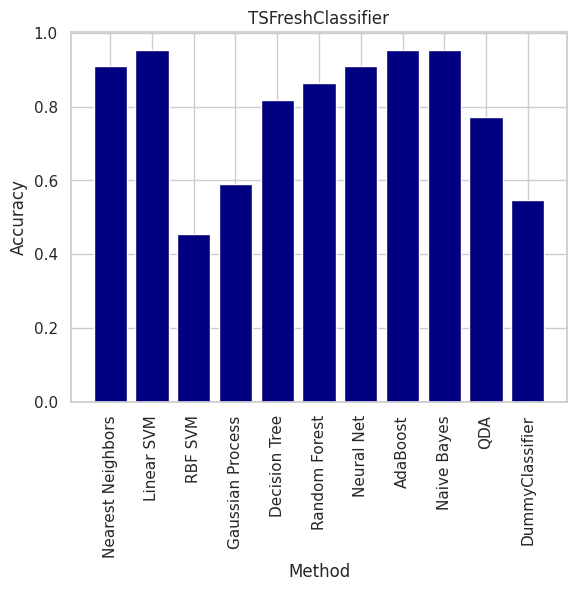

In [31]:
plotAccuracy(scores, names, 'TSFreshClassifier')

--------------------------------------